In [59]:
# Pyhthon 3.7 모델 설치
import sys

assert sys.version_info >= (3, 7)

In [60]:
!pip install tensorflow

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [61]:
import sys
# google colab의 경우 나눔 폰트를 설치
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [62]:
# 모델 튜닝을 위해 keras-tuner를 설치
!pip install keras-tuner


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [63]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    # Colab에서 필요한 추가 코드 (예: 파일 업로드)
    uploaded = files.upload()
else:
    print("This code is not running in Google Colab.")


This code is not running in Google Colab.


In [64]:
import pandas as pd

df = pd.read_csv("datasets/BostonHousing.csv")
X = df.iloc[:, :-1].values  # 입력 특성
y = df.iloc[:, -1].values  # 출력 값

In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로드
df = pd.read_csv("datasets/BostonHousing.csv")
X = df.iloc[:, :-1].values  # 입력 특성
y = df.iloc[:, -1].values  # 출력 값

# 데이터 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = np.nan_to_num(scaler.fit_transform(X_train))
X_valid_scaled = np.nan_to_num(scaler.transform(X_valid))
X_test_scaled = np.nan_to_num(scaler.transform(X_test))
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)
y_test = np.nan_to_num(y_test)

# 사용자 정의 HuberLoss 함수
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# 모델 구조 정의
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    optimizer = hp.Choice("optimizer", values=["adam", "sgd"])

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(X_train_scaled.shape[1],)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(tf.keras.layers.Dense(1))

    loss = HuberLoss(threshold=hp.Float("threshold", min_value=0.5, max_value=5.0, step=0.5))
    model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])
    return model

# 이 문단부터 하이퍼 파라미터
# Keras Tuner 설정
tuner = kt.Hyperband(
    build_model,
    objective="val_mae",
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="huber_loss_tuning",
    max_consecutive_failed_trials=10
)

# 하이퍼파라미터 검색 실행
tuner.search(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    verbose=2
)

# 최적의 하이퍼파라미터로 모델 재설정 및 훈련
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=20)

# 모델 평가
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

# 모델 저장
model.save("final_model.keras")

# 최종 평가 결과 출력
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Reloading Tuner from tuner_dir/huber_loss_tuning/tuner0.json
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 18.5497 - mae: 19.1442 - val_loss: 8.3881 - val_mae: 8.6297
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8300 - mae: 9.3757 - val_loss: 7.7805 - val_mae: 7.8725
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9446 - mae: 8.0884 - val_loss: 7.1073 - val_mae: 7.5297
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1556 - mae: 7.2139 - val_loss: 6.8184 - val_mae: 7.3300
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3751 - mae: 7.4388 - val_loss: 6.5157 - val_mae: 6.6491
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7221 - mae: 7.1840 - val_loss: 6.6721 - val_mae: 7.6172
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4934 - mae: 7.3172 - val_loss: 6.4547 - val_mae: 6.4375
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4888 - mae: 6.1814 - val_loss: 6.4538 - val_mae: 6.7617
Epoch 9/

In [66]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


In [67]:
print("Train Datas Shape : {}".format(train_data.shape))
print("Train Labels Shape : {}".format(train_targets.shape))

Train Datas Shape : (404, 13)
Train Labels Shape : (404,)


In [68]:
display(train_data[0])
display(train_targets[0:10])

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [69]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


In [70]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_network(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [71]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 150
all_scores = []
all_history = []
for i in range(k):
    print('폴드 번호 #{}'.format(i))
    fold_start_index = i * num_val_samples
    fold_end_index = (i + 1) * num_val_samples

    val_data = train_data[fold_start_index : fold_end_index]
    val_targets = train_targets[fold_start_index : fold_end_index]

    partial_train_data = np.concatenate(
        [train_data[:fold_start_index], train_data[fold_end_index:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:fold_start_index], train_targets[fold_end_index:]],
        axis=0
    )

    model = build_network((partial_train_data.shape[1], ))
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        validation_data=(val_data, val_targets),
        batch_size=1,
        verbose=0
    )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mse)
    all_history.append(history.history)

폴드 번호 #0
폴드 번호 #1
폴드 번호 #2
폴드 번호 #3


In [72]:
val_mae_lst = [hist['val_mae'] for hist in all_history]
val_mae_lst = np.array(list(val_mae_lst))
avg_mae = [
    np.mean([x[i] for x in val_mae_lst]) for i in range(num_epochs)
]

In [73]:
val_mae_lst = [hist['val_loss'] for hist in all_history]
val_mae_lst = np.array(list(val_mae_lst))
avg_mae = [
    np.mean([x[i] for x in val_mae_lst]) for i in range(num_epochs)
]

In [74]:
import matplotlib.pyplot as plt
def smooth_curve(points, factor=.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [75]:
def show_graph(data):
    smooth_data = smooth_curve(data)
    plt.plot(range(1, len(smooth_data) + 1), smooth_data)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

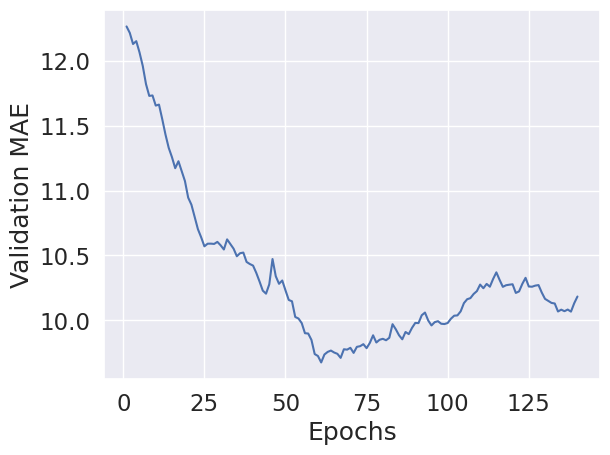

In [76]:
show_graph(avg_mae[10:])

키 설정


In [77]:
# all_history 내 각 요소의 키를 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history keys:", hist.keys())


Fold 0 history keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 1 history keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 2 history keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Fold 3 history keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [78]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} keys: {list(hist.keys())}")


Fold 0 keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 1 keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 2 keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 3 keys: ['loss', 'mae', 'val_loss', 'val_mae']


In [79]:
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]


In [80]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} history:", hist)


Fold 0 history: {'loss': [209.83575439453125, 25.111785888671875, 18.90439224243164, 16.507911682128906, 14.482107162475586, 13.638279914855957, 11.813788414001465, 11.711095809936523, 11.295975685119629, 10.758286476135254, 10.031143188476562, 10.544122695922852, 9.209615707397461, 9.542400360107422, 9.34768009185791, 9.533616065979004, 9.281434059143066, 8.909250259399414, 9.256231307983398, 8.483621597290039, 8.388113975524902, 8.312490463256836, 8.30117416381836, 8.119783401489258, 8.022085189819336, 7.613377094268799, 7.980684757232666, 7.292155742645264, 7.095829486846924, 7.027052879333496, 7.4034104347229, 6.932100772857666, 7.556177139282227, 6.343416690826416, 6.634040832519531, 6.705993175506592, 6.440128326416016, 6.445218086242676, 6.46658992767334, 6.119762420654297, 5.871985912322998, 5.666900157928467, 5.811185359954834, 5.537014961242676, 5.973600387573242, 5.444671630859375, 5.575969696044922, 5.031955718994141, 5.204774856567383, 5.48284912109375, 5.2859063148498535,

In [81]:
# 각 폴드의 history에서 키 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history keys: {list(hist.keys())}")


Fold 0 history keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 1 history keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 2 history keys: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 3 history keys: ['loss', 'mae', 'val_loss', 'val_mae']


In [82]:
# val_mae_lst 추출
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]

# numpy 배열로 변환
val_mae_lst = np.array(val_mae_lst)

# 에포크별 평균 MAE 계산
avg_mae = [
    np.mean(val_mae_lst[:, i]) for i in range(val_mae_lst.shape[1])
]

print("에포크별 평균 MAE:", avg_mae)


에포크별 평균 MAE: [np.float64(3.964280903339386), np.float64(3.2147467732429504), np.float64(2.929416596889496), np.float64(2.75823575258255), np.float64(2.684863030910492), np.float64(2.6390702724456787), np.float64(2.7369697093963623), np.float64(2.6192981004714966), np.float64(2.5683485865592957), np.float64(2.6291328072547913), np.float64(2.6093058586120605), np.float64(2.519968569278717), np.float64(2.4334322214126587), np.float64(2.499549984931946), np.float64(2.3984567523002625), np.float64(2.378615438938141), np.float64(2.3529053926467896), np.float64(2.467277407646179), np.float64(2.5518699884414673), np.float64(2.3750035762786865), np.float64(2.483811140060425), np.float64(2.361636161804199), np.float64(2.322453796863556), np.float64(2.3464366793632507), np.float64(2.356835126876831), np.float64(2.358745753765106), np.float64(2.4775009751319885), np.float64(2.3406409323215485), np.float64(2.2903208434581757), np.float64(2.2430146038532257), np.float64(2.3279454708099365), np.float

In [83]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} history data:", hist)


Fold 0 history data: {'loss': [209.83575439453125, 25.111785888671875, 18.90439224243164, 16.507911682128906, 14.482107162475586, 13.638279914855957, 11.813788414001465, 11.711095809936523, 11.295975685119629, 10.758286476135254, 10.031143188476562, 10.544122695922852, 9.209615707397461, 9.542400360107422, 9.34768009185791, 9.533616065979004, 9.281434059143066, 8.909250259399414, 9.256231307983398, 8.483621597290039, 8.388113975524902, 8.312490463256836, 8.30117416381836, 8.119783401489258, 8.022085189819336, 7.613377094268799, 7.980684757232666, 7.292155742645264, 7.095829486846924, 7.027052879333496, 7.4034104347229, 6.932100772857666, 7.556177139282227, 6.343416690826416, 6.634040832519531, 6.705993175506592, 6.440128326416016, 6.445218086242676, 6.46658992767334, 6.119762420654297, 5.871985912322998, 5.666900157928467, 5.811185359954834, 5.537014961242676, 5.973600387573242, 5.444671630859375, 5.575969696044922, 5.031955718994141, 5.204774856567383, 5.48284912109375, 5.285906314849

In [84]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mean_absolute_error']  # 또는 ['mae']
)


In [85]:
# 모든 폴드의 history 데이터 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history:")
    for key, value in hist.items():
        print(f"  {key}: {value[:5]}...")  # 처음 5개의 값만 출력


Fold 0 history:
  loss: [209.83575439453125, 25.111785888671875, 18.90439224243164, 16.507911682128906, 14.482107162475586]...
  mae: [10.504104614257812, 3.6033785343170166, 3.0662283897399902, 2.890789031982422, 2.725583791732788]...
  val_loss: [28.728242874145508, 18.75067901611328, 15.221073150634766, 14.082649230957031, 12.882770538330078]...
  val_mae: [3.569485902786255, 2.928100824356079, 2.80576229095459, 2.6050479412078857, 2.727576494216919]...
Fold 1 history:
  loss: [207.32730102539062, 23.3598690032959, 16.139009475708008, 14.050117492675781, 12.37559986114502]...
  mae: [10.641982078552246, 3.2648115158081055, 2.7366795539855957, 2.5419609546661377, 2.3926494121551514]...
  val_loss: [22.075035095214844, 15.030193328857422, 13.256113052368164, 13.067120552062988, 11.951194763183594]...
  val_mae: [3.56803035736084, 2.907572031021118, 2.747429847717285, 2.723496198654175, 2.59912109375]...
Fold 2 history:
  loss: [226.1033172607422, 27.126869201660156, 18.25173568725586,

In [86]:
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]


In [87]:
val_mae_lst = []
for hist in all_history:
    if 'val_mean_absolute_error' in hist:
        val_mae_lst.append(hist['val_mean_absolute_error'])
    elif 'val_mae' in hist:  # 다른 대체 키 확인
        val_mae_lst.append(hist['val_mae'])
    else:
        print("경고: 이 history에 'val_mean_absolute_error' 또는 'val_mae'가 없습니다.", hist.keys())


In [88]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mean_absolute_error']  # 또는 'mae'
)


In [89]:
# 모든 history 데이터에서 문제가 있는 항목 확인
for i, hist in enumerate(all_history):
    if not isinstance(hist, dict):
        print(f"Fold {i} 데이터가 잘못되었습니다: {hist}")
    elif 'val_mean_absolute_error' not in hist:
        print(f"Fold {i}에서 'val_mean_absolute_error' 키가 없습니다. 키들: {list(hist.keys())}")


Fold 0에서 'val_mean_absolute_error' 키가 없습니다. 키들: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 1에서 'val_mean_absolute_error' 키가 없습니다. 키들: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 2에서 'val_mean_absolute_error' 키가 없습니다. 키들: ['loss', 'mae', 'val_loss', 'val_mae']
Fold 3에서 'val_mean_absolute_error' 키가 없습니다. 키들: ['loss', 'mae', 'val_loss', 'val_mae']


In [90]:
# val_mae_lst를 numpy 배열로 변환
val_mae_lst = np.array(val_mae_lst)

# 에포크별 평균 MAE 계산
avg_mae = [
    np.mean(val_mae_lst[:, i]) for i in range(val_mae_lst.shape[1])
]

print("에포크별 평균 MAE:", avg_mae)


에포크별 평균 MAE: [np.float64(3.964280903339386), np.float64(3.2147467732429504), np.float64(2.929416596889496), np.float64(2.75823575258255), np.float64(2.684863030910492), np.float64(2.6390702724456787), np.float64(2.7369697093963623), np.float64(2.6192981004714966), np.float64(2.5683485865592957), np.float64(2.6291328072547913), np.float64(2.6093058586120605), np.float64(2.519968569278717), np.float64(2.4334322214126587), np.float64(2.499549984931946), np.float64(2.3984567523002625), np.float64(2.378615438938141), np.float64(2.3529053926467896), np.float64(2.467277407646179), np.float64(2.5518699884414673), np.float64(2.3750035762786865), np.float64(2.483811140060425), np.float64(2.361636161804199), np.float64(2.322453796863556), np.float64(2.3464366793632507), np.float64(2.356835126876831), np.float64(2.358745753765106), np.float64(2.4775009751319885), np.float64(2.3406409323215485), np.float64(2.2903208434581757), np.float64(2.2430146038532257), np.float64(2.3279454708099365), np.float

In [91]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [92]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/BostonHousing2.csv")




In [93]:
df.head()

,TOWN,LON,LAT,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [94]:
# 그래프 배경 설정
sns.set_style('darkgrid')

In [95]:
# shape (dimension)
df.shape

(506, 17)

In [96]:
# 결측치
df.isnull().sum()

TOWN       0
LON        0
LAT        0
CMEDV      0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [97]:
# data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TOWN     506 non-null    object 
 1   LON      506 non-null    float64
 2   LAT      506 non-null    float64
 3   CMEDV    506 non-null    float64
 4   CRIM     506 non-null    float64
 5   ZN       506 non-null    float64
 6   INDUS    506 non-null    float64
 7   CHAS     506 non-null    int64  
 8   NOX      506 non-null    float64
 9   RM       506 non-null    float64
 10  AGE      506 non-null    float64
 11  DIS      506 non-null    float64
 12  RAD      506 non-null    int64  
 13  TAX      506 non-null    int64  
 14  PTRATIO  506 non-null    float64
 15  B        506 non-null    float64
 16  LSTAT    506 non-null    float64
dtypes: float64(13), int64(3), object(1)
memory usage: 67.3+ KB


In [98]:
# numerical variable
df.describe()

,LON,LAT,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,-71.056389,42.216440,22.528854,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,0.075405,0.061777,9.182176,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,-71.289500,42.030000,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,-71.093225,42.180775,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,-71.052900,42.218100,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,-71.019625,42.252250,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,-70.810000,42.381000,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [25]:
# 기초 통계량
df['medv'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

<Axes: >

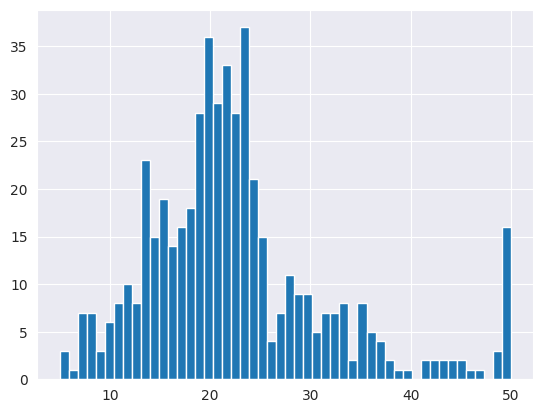

In [26]:
# 분포
df['medv'].hist(bins=50)

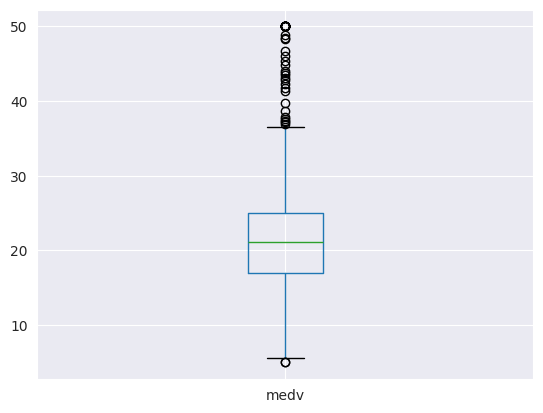

In [27]:
# boxplot - Pandas
df.boxplot(column=['medv'])
plt.show()

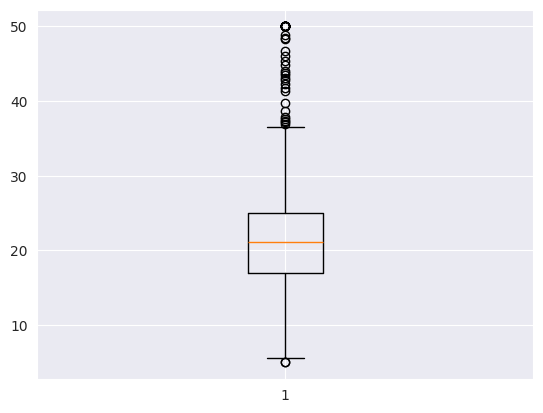

In [28]:
# boxplot - matplotlib
plt.boxplot(df['medv'])
plt.show()


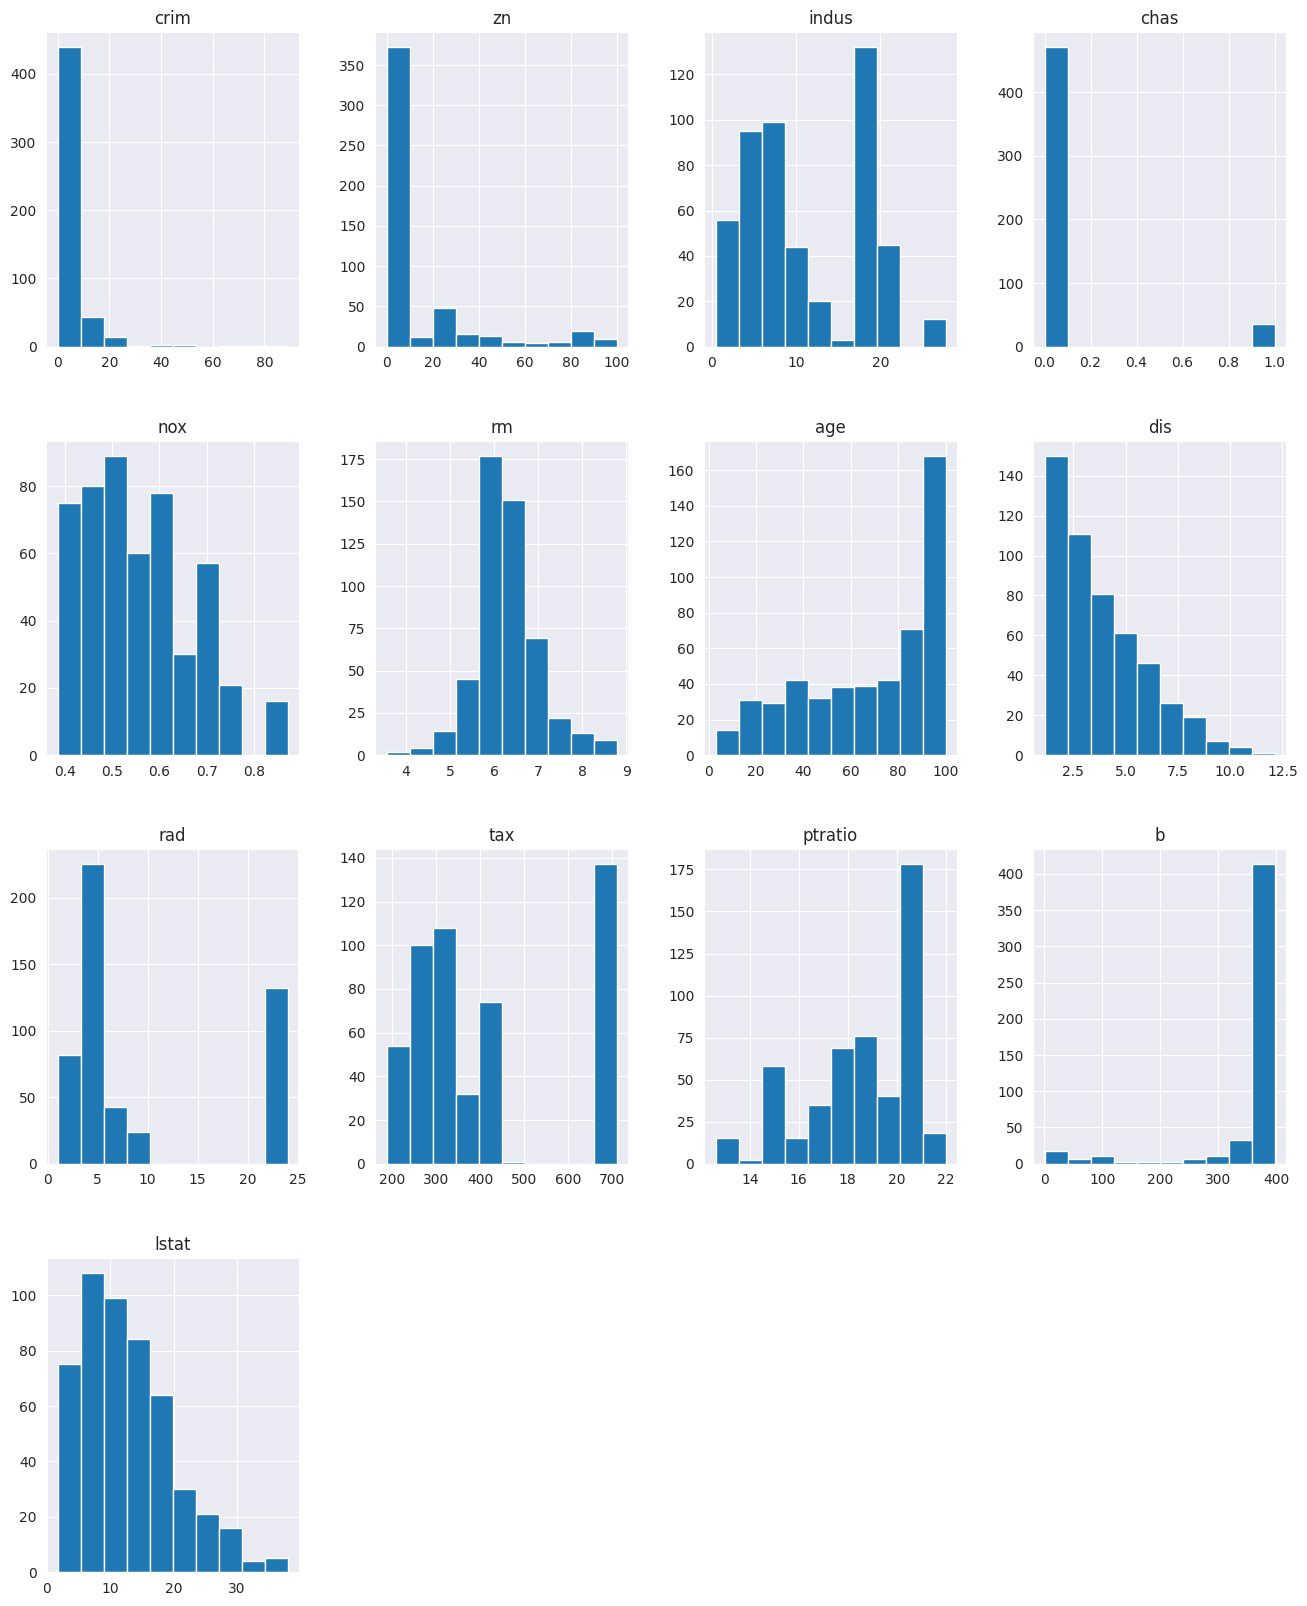

In [ ]:
# numerical features (except "LON" & "LAT")
numerical_columns = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

fig = plt.figure(figsize = (16, 20))
ax = fig.gca()  # Axes 생성

df[numerical_columns].hist(ax=ax)
plt.show()

In [31]:
# Person 상관계수
cols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

corr = df[cols].corr(method = 'pearson')
corr


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


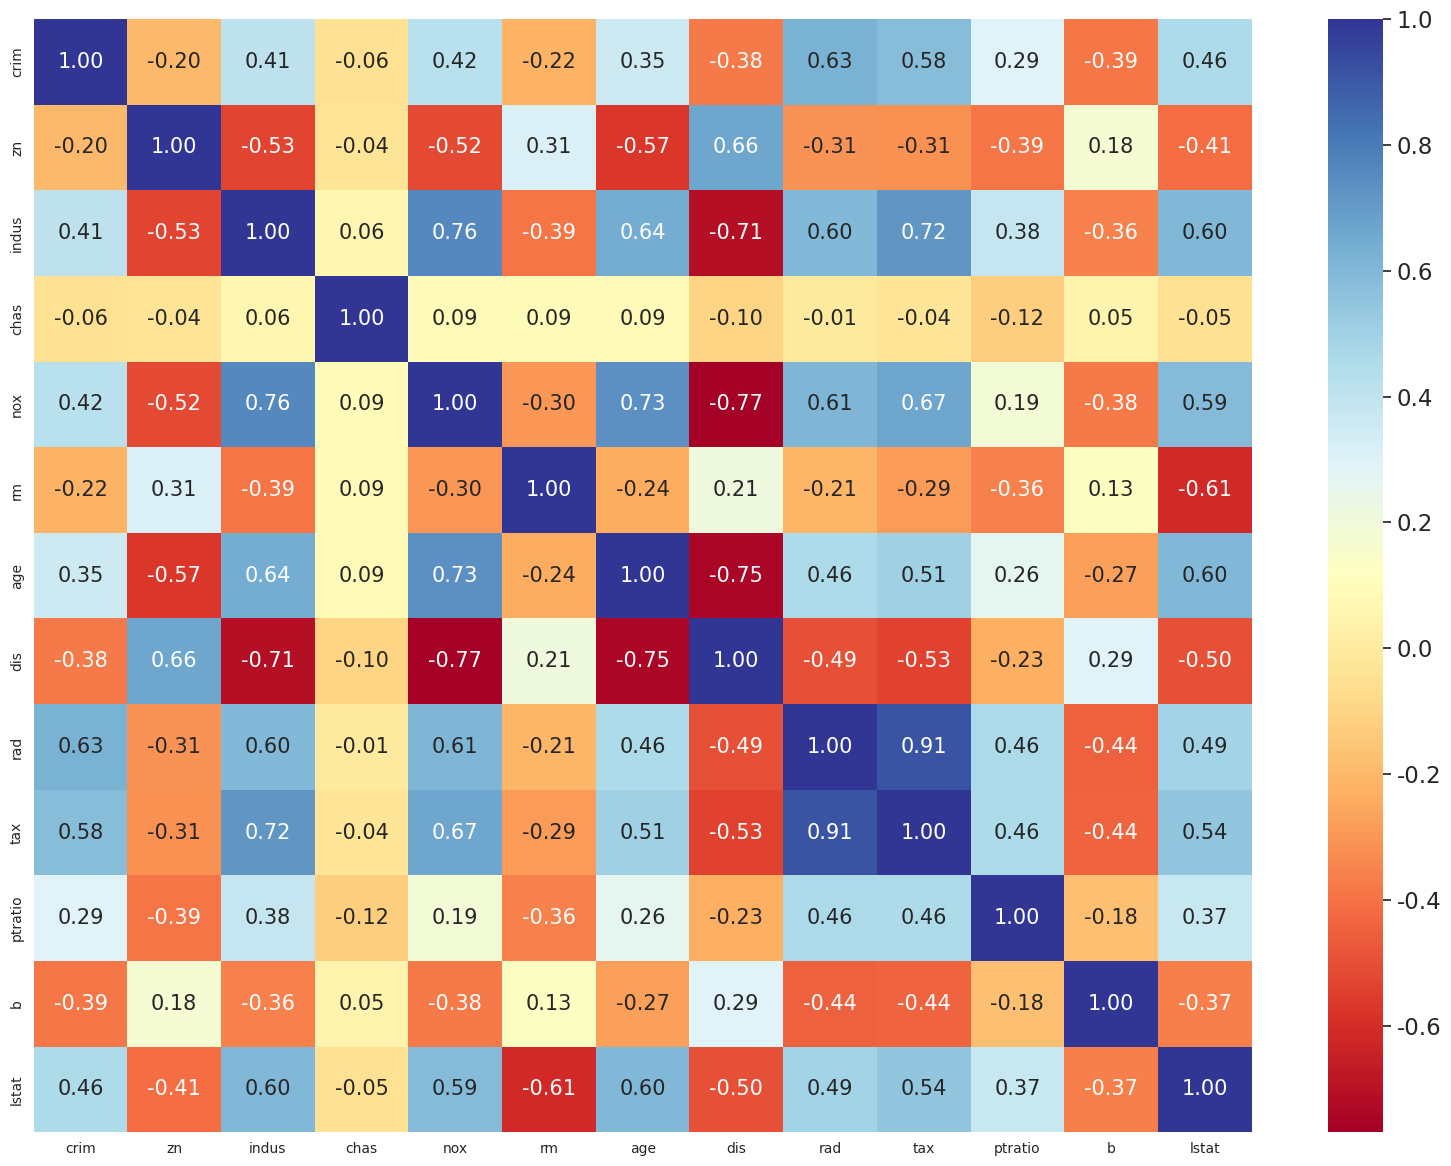

In [32]:
# 히트맵
fig = plt.figure(figsize = (16, 12))
ax = fig.gca()

sns.set(font_scale = 1.5)  # 히트맵 폰트 사이즈
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = cols, xticklabels = cols, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

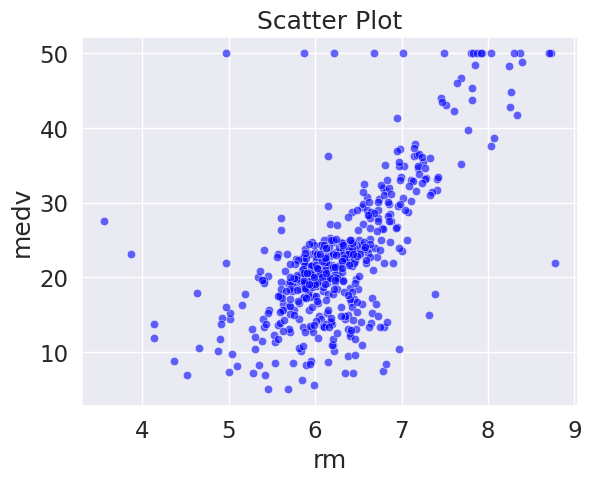

In [ ]:
# 방 개수에 따른 평균 주택 가격
sns.scatterplot(data=df, x='medv', y='rm', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

In [103]:
# 평균 주택 가격과 하위계증에 대한 관계성
sns.scatterplot(data=df, x='lstat', y='medv', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

ValueError: Could not interpret value `lstat` for `x`. An entry with this name does not appear in `data`.

<Axes: xlabel='crim', ylabel='medv'>

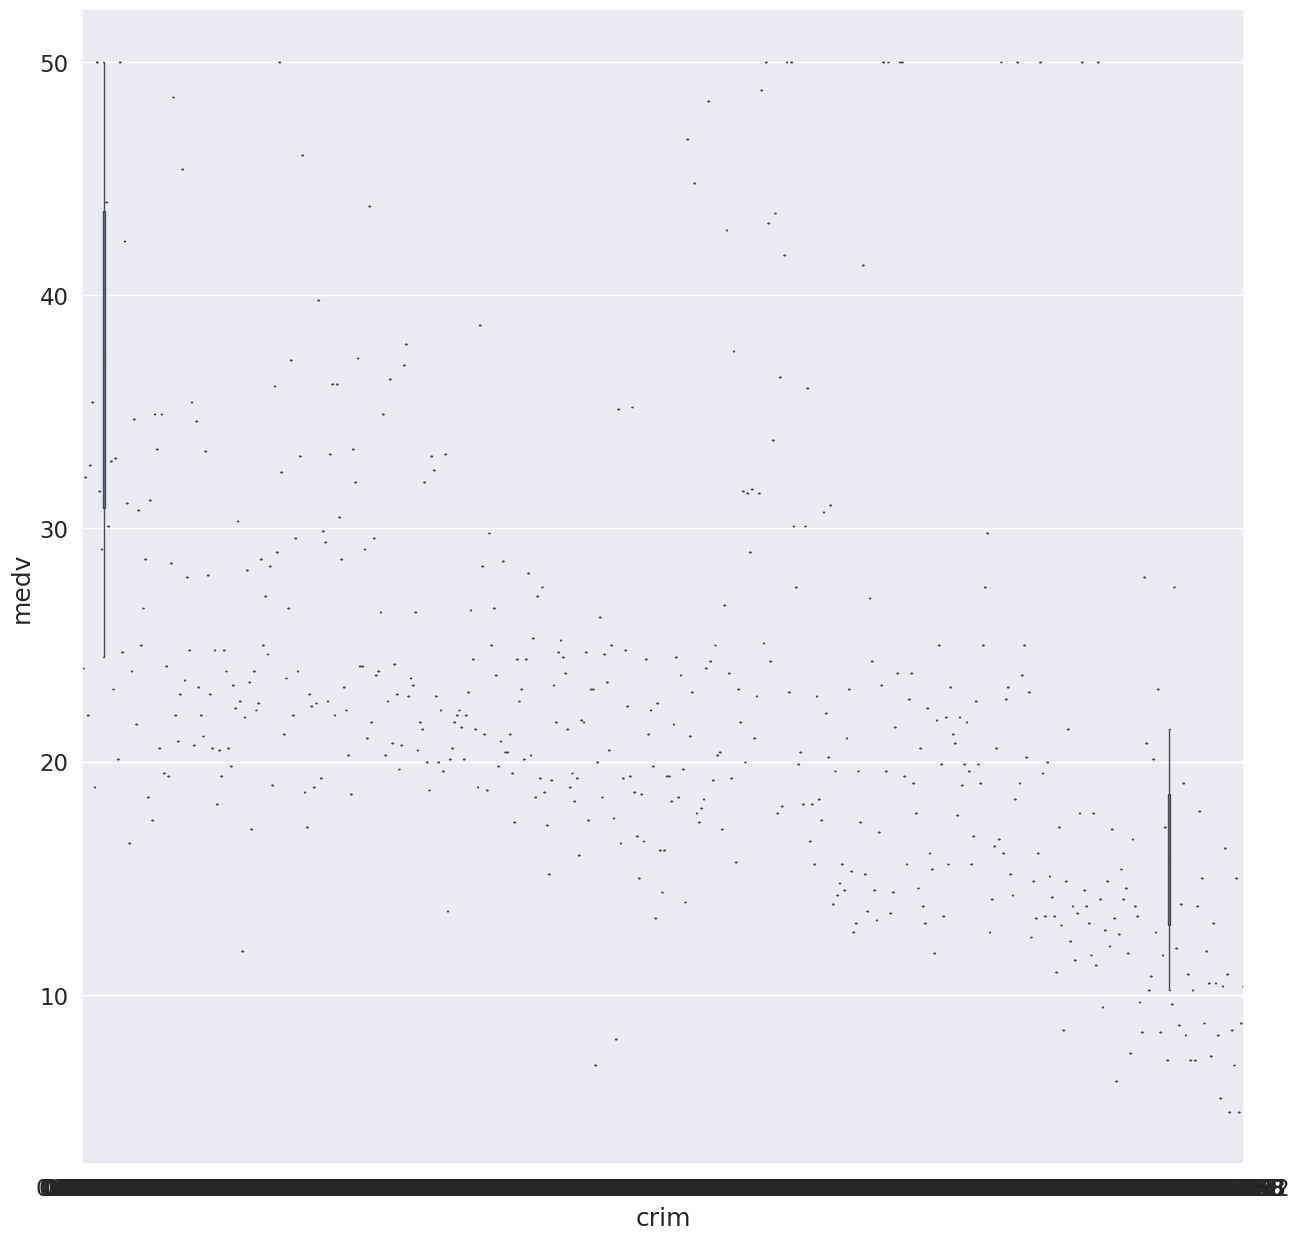

In [ ]:
# 범죄율과 주택 가격
fig = plt.figure(figsize = (15, 15))
sns.boxplot(x='crim', y='medv', data=df)

In [41]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [43]:

# feature standardization  (numerical_columns except dummy var.-"CHAS")
scaler = StandardScaler()  # 평균 0, 표준편차 1
scale_columns = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
df[scale_columns] = scaler.fit_transform(df[scale_columns])

In [44]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [45]:
# features for linear regression model
df[numerical_columns].head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [46]:

# split dataset into training & test
X = df[numerical_columns]
y = df['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
X_train.shape, y_train.shape

((404, 13), (404,))

In [48]:
X_test.shape, y_test.shape

((102, 13), (102,))

In [50]:
from sklearn import linear_model

# fit regression model in training set
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# predict in test set
pred_test = lr.predict(X_test)

In [51]:
# print coef
print(lr.coef_)

[-0.965745    1.3527328   0.12582714  0.54046677 -2.26676928  2.17277423
  0.12521318 -3.15644437  2.65621114 -1.87279982 -2.13903069  0.66773631
 -3.8854983 ]


In [52]:
# "feature - coefficients" DataFrame 만들기
coefs = pd.DataFrame(zip(df[numerical_columns].columns, lr.coef_), columns = ['feature', 'coefficients'])
coefs

,feature,coefficients
0,crim,-0.965745
1,zn,1.352733
2,indus,0.125827
3,chas,0.540467
4,nox,-2.266769
5,rm,2.172774
6,age,0.125213
7,dis,-3.156444
8,rad,2.656211
9,tax,-1.872800


In [53]:
# 크기 순서로 나열
coefs_new = coefs.reindex(coefs.coefficients.abs().sort_values(ascending=False).index)
coefs_new

,feature,coefficients
12,lstat,-3.885498
7,dis,-3.156444
8,rad,2.656211
4,nox,-2.266769
5,rm,2.172774
10,ptratio,-2.139031
9,tax,-1.872800
1,zn,1.352733
0,crim,-0.965745
11,b,0.667736


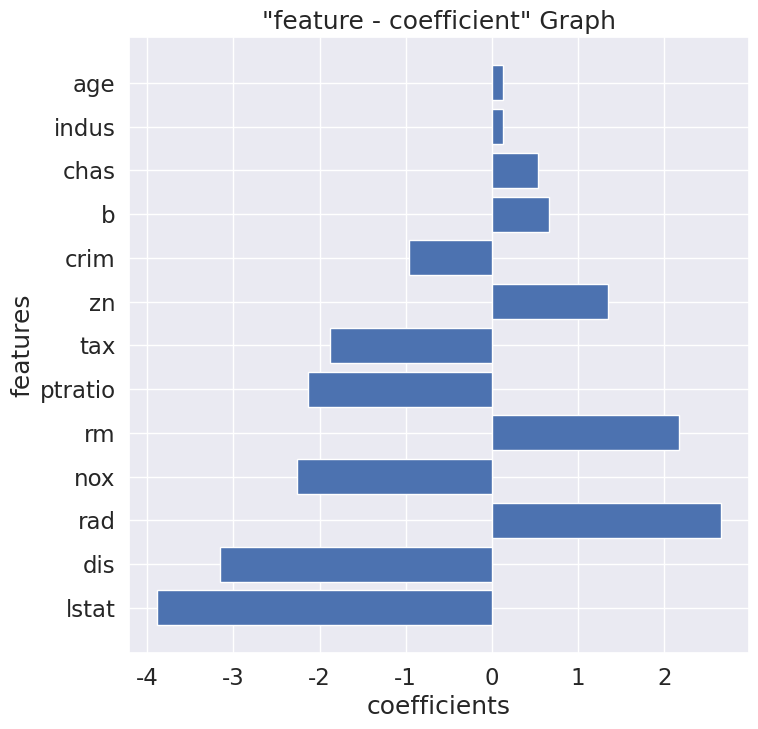

In [54]:
## coefficients 시각화

# figure size
plt.figure(figsize = (8, 8))

# bar plot
plt.barh(coefs_new['feature'], coefs_new['coefficients'])
plt.title('"feature - coefficient" Graph')
plt.xlabel('coefficients')
plt.ylabel('features')
plt.show()

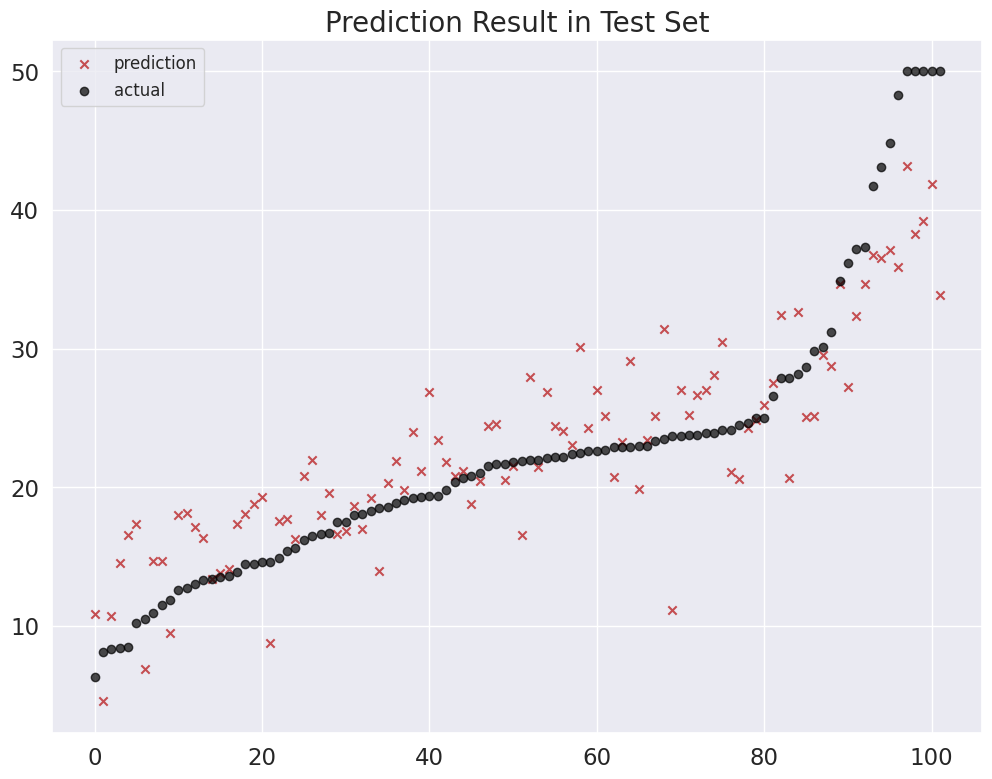

In [56]:
# 예측 결과 시각화 (test set)
df = pd.DataFrame({'actual': y_test, 'prediction': pred_test})
df = df.sort_values(by='actual').reset_index(drop=True)

plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['prediction'], marker='x', color='r')
plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['prediction', 'actual'], fontsize=12)
plt.show()

In [57]:
# R square
print(model.score(X_train, y_train))  # training set
print(model.score(X_test, y_test))  # test set

0.7293585058196337
0.7634174432138471


In [58]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# training set
pred_train = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, pred_train)))

# test set
print(sqrt(mean_squared_error(y_test, pred_test)))

4.675766751547772
4.8353734582005385
